In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.calibration import calibration_curve
import warnings
warnings.filterwarnings('ignore')

# Set style for better visualizations
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("✅ Environment setup complete")


✅ Environment setup complete


In [2]:
# Generate synthetic healthcare dataset with intentional bias patterns
np.random.seed(42)

def generate_biased_healthcare_data(n_samples=10000):
    """
    Generate synthetic healthcare data with realistic bias patterns
    that mirror real-world healthcare disparities
    """
    
    # Demographics
    race = np.random.choice(['White', 'Black', 'Hispanic', 'Asian'], 
                           size=n_samples, p=[0.65, 0.20, 0.12, 0.03])
    gender = np.random.choice(['Male', 'Female'], size=n_samples, p=[0.52, 0.48])
    age = np.random.normal(65, 20, n_samples).clip(18, 95)
    
    # Insurance type (proxy for socioeconomic status)
    insurance_probs = {
        'White': [0.60, 0.25, 0.10, 0.05],     # Private, Medicare, Medicaid, Uninsured
        'Black': [0.35, 0.30, 0.25, 0.10],
        'Hispanic': [0.30, 0.25, 0.30, 0.15],
        'Asian': [0.65, 0.20, 0.10, 0.05]
    }
    
    insurance = []
    for r in race:
        ins = np.random.choice(['Private', 'Medicare', 'Medicaid', 'Uninsured'], 
                              p=insurance_probs[r])
        insurance.append(ins)
    
    # Clinical features (with bias patterns)
    # Base risk factors
    temperature = np.random.normal(98.6, 2.5, n_samples)
    heart_rate = np.random.normal(80, 20, n_samples).clip(40, 180)
    blood_pressure_sys = np.random.normal(120, 25, n_samples).clip(70, 200)
    white_blood_count = np.random.lognormal(2.0, 0.5, n_samples).clip(3, 50)
    
    # Introduce bias patterns
    # 1. Measurement bias: Different normal ranges by demographics
    race_bias = {'White': 0, 'Black': 0.3, 'Hispanic': 0.2, 'Asian': -0.1}
    gender_bias = {'Male': 0, 'Female': 0.15}  # Historical underdiagnosis in females
    
    # Apply bias to clinical measurements
    for i in range(n_samples):
        temperature[i] += race_bias[race[i]] + gender_bias[gender[i]]
        heart_rate[i] += race_bias[race[i]] * 10
    
    # Generate sepsis outcome with biased patterns
    # Base probability
    sepsis_prob = (
        0.02 +  # baseline risk
        0.001 * (age - 65) +  # age effect
        0.01 * (temperature > 100.4) +  # fever
        0.005 * (heart_rate > 100) +  # tachycardia
        0.003 * (white_blood_count > 12)  # elevated WBC
    )
    
    # Add bias to outcome (reflecting real healthcare disparities)
    outcome_bias = {
        'White': 1.0,
        'Black': 1.3,      # Higher baseline risk
        'Hispanic': 1.2,   # Higher baseline risk
        'Asian': 0.9       # Lower baseline risk
    }
    
    gender_outcome_bias = {'Male': 1.0, 'Female': 0.85}  # Diagnostic bias
    
    for i in range(n_samples):
        sepsis_prob[i] *= outcome_bias[race[i]] * gender_outcome_bias[gender[i]]
    
    sepsis = np.random.binomial(1, sepsis_prob.clip(0, 1), n_samples)
    
    # Create DataFrame
    data = pd.DataFrame({
        'patient_id': range(1, n_samples + 1),
        'race': race,
        'gender': gender,
        'age': age,
        'insurance': insurance,
        'temperature': temperature,
        'heart_rate': heart_rate,
        'blood_pressure_sys': blood_pressure_sys,
        'white_blood_count': white_blood_count,
        'sepsis': sepsis
    })
    
    return data

# Generate the dataset
df = generate_biased_healthcare_data(10000)

print(f"✅ Generated dataset with {len(df)} patient records")
print(f"📊 Sepsis prevalence: {df['sepsis'].mean():.2%}")
print(f"🏥 Demographics:")
print(df[['race', 'gender', 'insurance']].describe())


✅ Generated dataset with 10000 patient records
📊 Sepsis prevalence: 2.33%
🏥 Demographics:
         race gender insurance
count   10000  10000     10000
unique      4      2         4
top     White   Male   Private
freq     6603   5143      5202


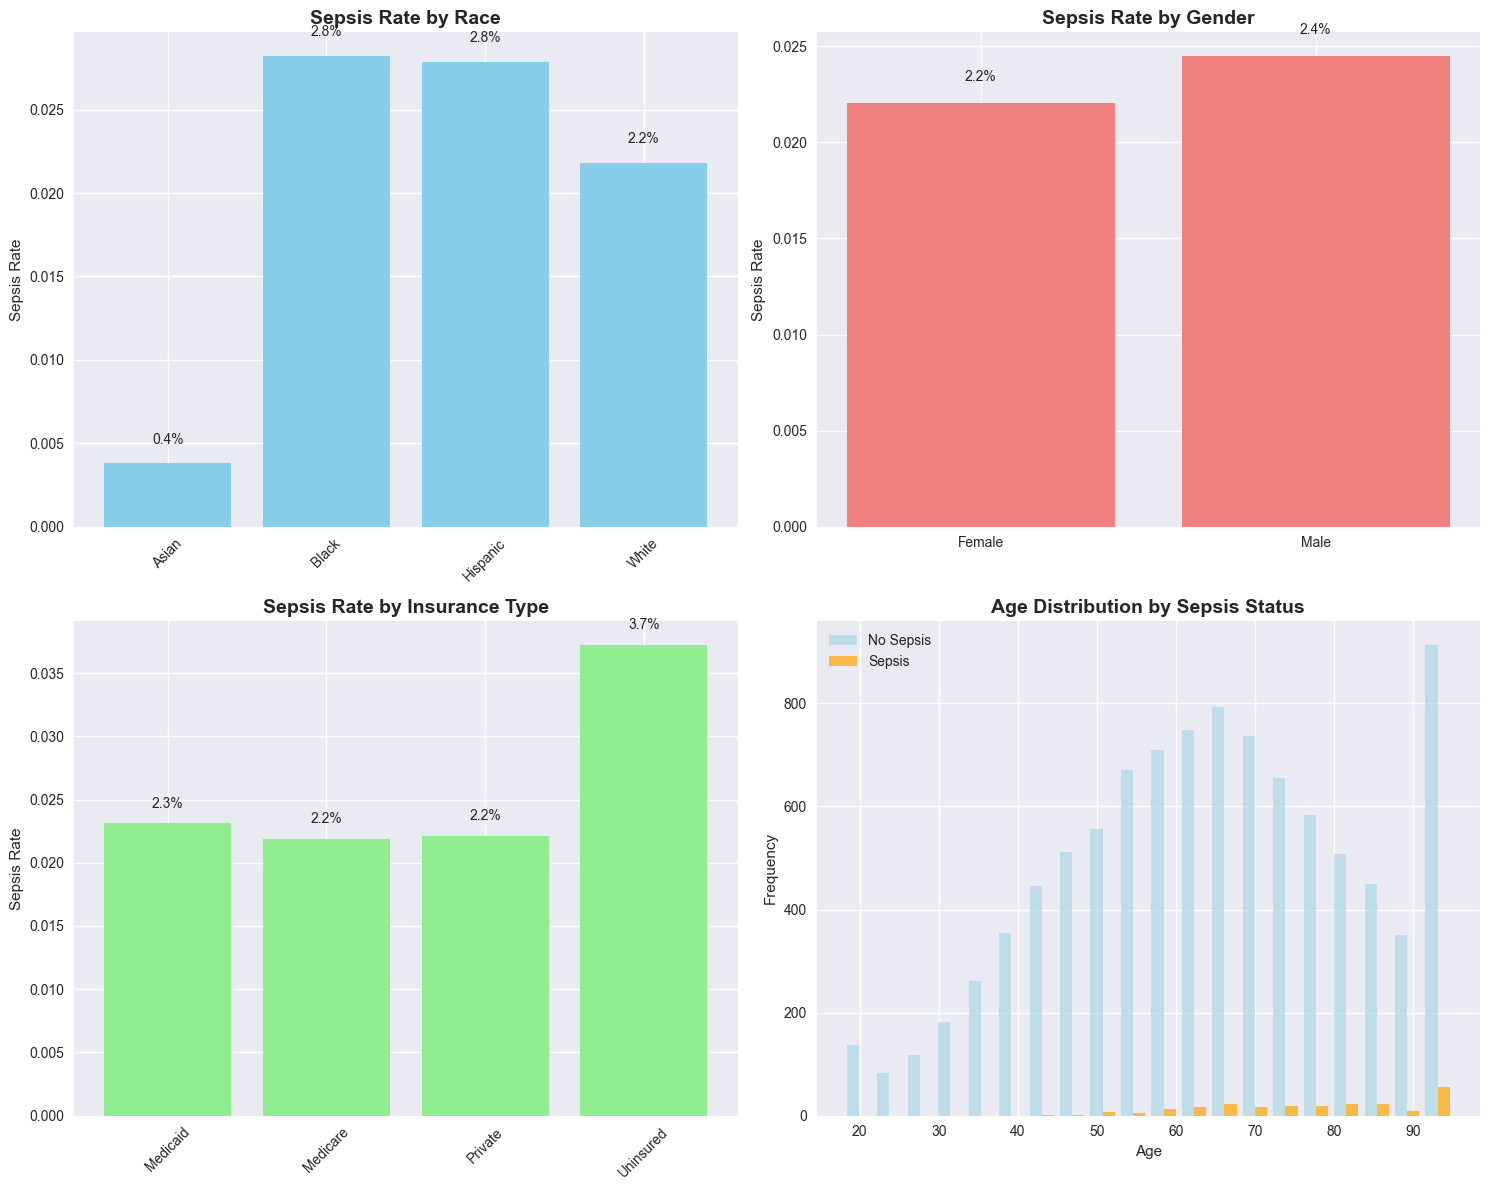

🔍 Key Bias Patterns Identified:
• Race disparities: 2.8% vs 0.4%
• Gender disparities: 2.4% vs 2.2%
• Insurance disparities: 3.7% vs 2.2%


In [ ]:
# Analyze sepsis rates by demographics
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Sepsis by race
sepsis_by_race = df.groupby('race')['sepsis'].agg(['count', 'sum', 'mean']).reset_index()
sepsis_by_race['rate'] = sepsis_by_race['mean']

axes[0,0].bar(sepsis_by_race['race'], sepsis_by_race['rate'], color='skyblue')
axes[0,0].set_title('Sepsis Rate by Race', fontsize=14, fontweight='bold')
axes[0,0].set_ylabel('Sepsis Rate')
axes[0,0].tick_params(axis='x', rotation=45)

# Add rate labels on bars
for i, v in enumerate(sepsis_by_race['rate']):
    axes[0,0].text(i, v + 0.001, f'{v:.1%}', ha='center', va='bottom')

# Sepsis by gender
sepsis_by_gender = df.groupby('gender')['sepsis'].agg(['count', 'sum', 'mean']).reset_index()
sepsis_by_gender['rate'] = sepsis_by_gender['mean']

axes[0,1].bar(sepsis_by_gender['gender'], sepsis_by_gender['rate'], color='lightcoral')
axes[0,1].set_title('Sepsis Rate by Gender', fontsize=14, fontweight='bold')
axes[0,1].set_ylabel('Sepsis Rate')

for i, v in enumerate(sepsis_by_gender['rate']):
    axes[0,1].text(i, v + 0.001, f'{v:.1%}', ha='center', va='bottom')

# Sepsis by insurance
sepsis_by_insurance = df.groupby('insurance')['sepsis'].agg(['count', 'sum', 'mean']).reset_index()
sepsis_by_insurance['rate'] = sepsis_by_insurance['mean']

axes[1,0].bar(sepsis_by_insurance['insurance'], sepsis_by_insurance['rate'], color='lightgreen')
axes[1,0].set_title('Sepsis Rate by Insurance Type', fontsize=14, fontweight='bold')
axes[1,0].set_ylabel('Sepsis Rate')
axes[1,0].tick_params(axis='x', rotation=45)

for i, v in enumerate(sepsis_by_insurance['rate']):
    axes[1,0].text(i, v + 0.001, f'{v:.1%}', ha='center', va='bottom')

# Age distribution by sepsis
axes[1,1].hist([df[df['sepsis']==0]['age'], df[df['sepsis']==1]['age']], 
               bins=20, alpha=0.7, label=['No Sepsis', 'Sepsis'], color=['lightblue', 'orange'])
axes[1,1].set_title('Age Distribution by Sepsis Status', fontsize=14, fontweight='bold')
axes[1,1].set_xlabel('Age')
axes[1,1].set_ylabel('Frequency')
axes[1,1].legend()

plt.tight_layout()
plt.show()

print("🔍 Key Bias Patterns Identified:")
print(f"• Race disparities: {sepsis_by_race['rate'].max():.1%} vs {sepsis_by_race['rate'].min():.1%}")
print(f"• Gender disparities: {sepsis_by_gender['rate'].max():.1%} vs {sepsis_by_gender['rate'].min():.1%}")
print(f"• Insurance disparities: {sepsis_by_insurance['rate'].max():.1%} vs {sepsis_by_insurance['rate'].min():.1%}")


In [ ]:
# Prepare features for modeling
# Create dummy variables for categorical features
features_df = pd.get_dummies(df[['race', 'gender', 'age', 'insurance', 
                                'temperature', 'heart_rate', 'blood_pressure_sys', 
                                'white_blood_count']], drop_first=True)

X = features_df
y = df['sepsis']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Train initial model (potentially biased)
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Generate predictions
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

# Overall performance
print("📊 Overall Model Performance:")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.3f}")
print(f"Precision: {precision_score(y_test, y_pred):.3f}")
print(f"Recall: {recall_score(y_test, y_pred):.3f}")
print(f"AUC-ROC: {roc_auc_score(y_test, y_prob):.3f}")

# Create test dataset with demographics for bias analysis
test_indices = X_test.index
test_demographics = df.loc[test_indices, ['race', 'gender', 'insurance']].copy()
test_demographics['y_true'] = y_test.values
test_demographics['y_pred'] = y_pred
test_demographics['y_prob'] = y_prob

print("\n✅ Model training completed")
print(f"📊 Test set size: {len(X_test)} patients")


📊 Overall Model Performance:
Accuracy: 0.977
Precision: 0.000
Recall: 0.000
AUC-ROC: 0.604

✅ Model training completed
📊 Test set size: 3000 patients


In [ ]:
def calculate_fairness_metrics(df, protected_attr, outcome_col='y_true', prediction_col='y_pred', prob_col='y_prob'):
    """
    Calculate comprehensive fairness metrics for bias detection
    """
    metrics = {}
    groups = df[protected_attr].unique()
    
    for group in groups:
        group_data = df[df[protected_attr] == group]
        
        # Basic performance metrics
        accuracy = accuracy_score(group_data[outcome_col], group_data[prediction_col])
        precision = precision_score(group_data[outcome_col], group_data[prediction_col], zero_division=0)
        recall = recall_score(group_data[outcome_col], group_data[prediction_col], zero_division=0)
        auc = roc_auc_score(group_data[outcome_col], group_data[prob_col]) if len(group_data[outcome_col].unique()) > 1 else 0
        
        # Fairness-specific metrics
        positive_rate = group_data[prediction_col].mean()  # Demographic parity
        
        # True positive rate (Equal opportunity)
        positive_cases = group_data[group_data[outcome_col] == 1]
        tpr = positive_cases[prediction_col].mean() if len(positive_cases) > 0 else 0
        
        # False positive rate
        negative_cases = group_data[group_data[outcome_col] == 0]
        fpr = negative_cases[prediction_col].mean() if len(negative_cases) > 0 else 0
        
        metrics[group] = {
            'sample_size': len(group_data),
            'base_rate': group_data[outcome_col].mean(),
            'positive_rate': positive_rate,
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'tpr': tpr,
            'fpr': fpr,
            'auc': auc
        }
    
    return metrics

def analyze_bias_by_attribute(df, attr_name):
    """
    Perform comprehensive bias analysis for a protected attribute
    """
    print(f"\n🔍 Bias Analysis: {attr_name.upper()}")
    print("=" * 50)
    
    metrics = calculate_fairness_metrics(df, attr_name)
    
    # Create summary table
    summary_df = pd.DataFrame(metrics).T
    summary_df = summary_df.round(3)
    
    print("📊 Performance by Group:")
    print(summary_df[['sample_size', 'base_rate', 'positive_rate', 'accuracy', 'recall', 'auc']])
    
    # Calculate fairness violations
    print("\n⚖️ Fairness Metrics:")
    
    # Demographic Parity Difference
    positive_rates = summary_df['positive_rate']
    dp_diff = positive_rates.max() - positive_rates.min()
    dp_status = "✅ PASS" if dp_diff <= 0.05 else "❌ FAIL"
    print(f"Demographic Parity Difference: {dp_diff:.3f} {dp_status} (threshold: ≤0.05)")
    
    # Equal Opportunity Difference
    tpr_values = summary_df['tpr']
    eo_diff = tpr_values.max() - tpr_values.min()
    eo_status = "✅ PASS" if eo_diff <= 0.03 else "❌ FAIL"
    print(f"Equal Opportunity Difference: {eo_diff:.3f} {eo_status} (threshold: ≤0.03)")
    
    # Equalized Odds (TPR and FPR)
    fpr_values = summary_df['fpr']
    fpr_diff = fpr_values.max() - fpr_values.min()
    eq_odds_status = "✅ PASS" if (eo_diff <= 0.03 and fpr_diff <= 0.03) else "❌ FAIL"
    print(f"Equalized Odds: TPR diff={eo_diff:.3f}, FPR diff={fpr_diff:.3f} {eq_odds_status}")
    
    # AUC Difference
    auc_values = summary_df['auc']
    auc_diff = auc_values.max() - auc_values.min()
    auc_status = "✅ PASS" if auc_diff <= 0.05 else "❌ FAIL"
    print(f"AUC Difference: {auc_diff:.3f} {auc_status} (threshold: ≤0.05)")
    
    return summary_df, {
        'demographic_parity': dp_diff,
        'equal_opportunity': eo_diff,
        'fpr_difference': fpr_diff,
        'auc_difference': auc_diff
    }

# Analyze bias for each protected attribute
race_metrics, race_fairness = analyze_bias_by_attribute(test_demographics, 'race')
gender_metrics, gender_fairness = analyze_bias_by_attribute(test_demographics, 'gender')
insurance_metrics, insurance_fairness = analyze_bias_by_attribute(test_demographics, 'insurance')



🔍 Bias Analysis: RACE
📊 Performance by Group:
          sample_size  base_rate  positive_rate  accuracy  recall    auc
White          2014.0      0.022            0.0     0.978     0.0  0.618
Black           559.0      0.032            0.0     0.968     0.0  0.616
Hispanic        343.0      0.023            0.0     0.977     0.0  0.469
Asian            84.0      0.000            0.0     1.000     0.0  0.000

⚖️ Fairness Metrics:
Demographic Parity Difference: 0.000 ✅ PASS (threshold: ≤0.05)
Equal Opportunity Difference: 0.000 ✅ PASS (threshold: ≤0.03)
Equalized Odds: TPR diff=0.000, FPR diff=0.000 ✅ PASS
AUC Difference: 0.618 ❌ FAIL (threshold: ≤0.05)

🔍 Bias Analysis: GENDER
📊 Performance by Group:
        sample_size  base_rate  positive_rate  accuracy  recall    auc
Female       1453.0      0.023            0.0     0.977     0.0  0.597
Male         1547.0      0.024            0.0     0.976     0.0  0.612

⚖️ Fairness Metrics:
Demographic Parity Difference: 0.000 ✅ PASS (threshold: